# 5点の強結合格子（2022年春 Lab2）

```{note}
このNotebookはQiskit v0.44の仕様に合わせてコードを改変しています。
```

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.visualization import *

from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
t = Parameter('t')

In [4]:
# https://github.com/qiskit-community/Quantum-Challenge-Grader/blob/main/qc_grader/challenges/spring_2022/helpers/__init__.py
from qiskit.circuit import Instruction

def generate_ZZ(t: Parameter) -> Instruction:
    ZZ_qr = QuantumRegister(2)
    ZZ_qc = QuantumCircuit(ZZ_qr, name='ZZ')
    ZZ_qc.cnot(0, 1)
    ZZ_qc.rz(2 * t, 1)
    ZZ_qc.cnot(0, 1)
    ZZ = ZZ_qc.to_instruction()
    return ZZ
    
def generate_XX(t: Parameter) -> Instruction:
    ZZ = generate_ZZ(t)
    XX_qr = QuantumRegister(2)
    XX_qc = QuantumCircuit(XX_qr, name='XX')
    XX_qc.h([0, 1])
    XX_qc.append(ZZ, [0, 1])
    XX_qc.h([0, 1])
    XX = XX_qc.to_instruction()
    return XX

def generate_YY(t: Parameter) -> Instruction:
    ZZ = generate_ZZ(t)
    YY_qr = QuantumRegister(2)
    YY_qc = QuantumCircuit(YY_qr, name='YY')
    YY_qc.sdg([0, 1])
    YY_qc.h([0, 1])
    YY_qc.append(ZZ, [0, 1])
    YY_qc.h([0, 1])
    YY_qc.s([0, 1])
    YY = YY_qc.to_instruction()
    return YY

In [5]:
XX = generate_XX(t)
YY = generate_YY(t)

このExerciseでは、5格子点の強格子結合をシミュレーションします。最初に、全ての点のエネルギーが同じ値の強結合ハミルトニアンについて見てみます。5点の強結合格子は以下のハミルトニアンになることを思い出してください：

$$H_{\rm tb}/\hbar = J \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1})$$

このChallengeでは、一般性を損なわずに、$\hbar=1$ で $J=1$と設定します。

## 粒子輸送

強結合系では、粒子の伝搬は連続時間による量子ランダムウォーク(Quantum  Randm Walk、QRW)で表現できます。量子ランダムウォークは古典のランダムウォークの量子力学的なアナロジーです。ランダムウォークはランダムに動く粒子が始点から動いていく過程です。古典的なランダムウォークの元では、時間$t$に始点からの位置$r$で粒子を発見する確率は、ガウス分布に従います：

$$ p_{\text{classical}}(r,t) \propto e^{-|r|^2/t} $$

この確率分布の標準偏差は時間の平方根で増大します：$\sigma_{\text{classical}}= \sqrt{t}$.　単一粒子の重ね合わせや干渉などの量子力学的性質は古典と量子ランダムウォークの間に質的な違いをもたらします。量子ランダムウォークの元では、始点からの位置$r$において量子を発見する確率は[第１種ベッセル関数](https://en.wikipedia.org/wiki/Bessel_function)に従います：

$$ p_{\text{quantum}}(r,t) \propto |J_r(2t)|^2 $$
この確率分布の標準偏差は時間に対して線形です： $\sigma_{\text{quantum}} = t$.

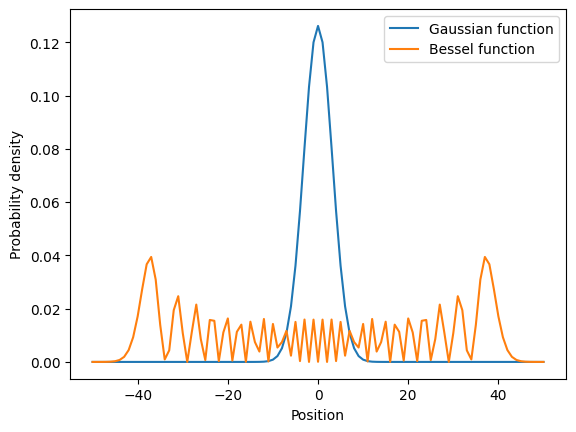

In [6]:
from scipy.special import jv

t_test = 20
r = np.linspace(-50,50,101)
gaussian = np.exp(-r**2/t_test) / np.sum(np.exp(-r**2/t_test))
bessel = np.abs(jv(r,2*t_test))**2 / np.sum(np.abs(jv(r,2*t_test))**2)

plt.plot(r, gaussian, label=r'Gaussian function')
plt.plot(r, bessel, label=r'Bessel function')

plt.xlabel('Position')
plt.ylabel('Probability density')
plt.legend()
plt.show()

格子における粒子の空間伝搬は、初期位置から相対的に、平均二乗変位$⟨x^2⟩= \sum_i p_i x^2_i$によって計算されます。ここで、$p_i$は位置$i$において粒子を発見する確率です。古典のランダムウォークは時間に対して、$⟨x^2⟩ \propto t$で拡散伝搬します。一方、QRWは平均二乗変位に対して$⟨x^2⟩ \propto t^2$のように弾道伝搬性を示します。

量子ランダムウォークが古典ランダムウォークと比べて2次のスピードアップがあることは、グローバー探索アルゴリズムが古典の探索に比べて2次のスピードアップがあることと類似しています！

### Challenge question 2a

````{admonition} 時間発展回路の構築
強結合のハミルトニアンにおいてトロッター展開の時間発展を作る回路にXXゲートとYYゲートを追加してください。 

```python
num_qubits = 5 ## DO NOT EDIT

Trot_tb_qr = QuantumRegister(num_qubits)
Trot_tb_qc = QuantumCircuit(Trot_tb_qr, name='Trot')

###EDIT CODE BELOW



###DO NOT EDIT BELOW

Trot_tb_gate = Trot_tb_qc.to_instruction()

Trot_tb_qc.draw("mpl")
```
````

### 解答例

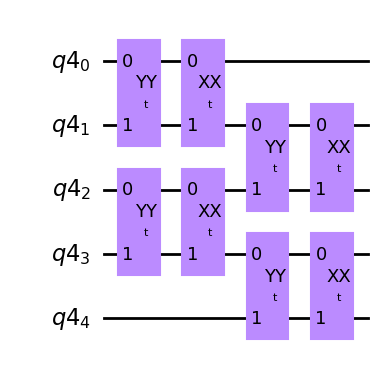

In [7]:
num_qubits = 5 ## DO NOT EDIT

Trot_tb_qr = QuantumRegister(num_qubits)
Trot_tb_qc = QuantumCircuit(Trot_tb_qr, name='Trot')

Trot_tb_qc.append(YY, [0, 1])
Trot_tb_qc.append(XX, [0, 1])

Trot_tb_qc.append(YY, [2, 3])
Trot_tb_qc.append(XX, [2, 3])

Trot_tb_qc.append(YY, [1, 2])
Trot_tb_qc.append(XX, [1, 2])

Trot_tb_qc.append(YY, [3, 4])
Trot_tb_qc.append(XX, [3, 4])

Trot_tb_gate = Trot_tb_qc.to_instruction()

Trot_tb_qc.draw("mpl")

```{admonition} 解説
:class: tip
lab1の2.3 トロッター分解の式より、まず最初に偶数量子ビットである$i=0,~2$の場合について$YY$、$XX$をかける。その後、奇数量子ビットである$i=1,~3$について同様に$YY$、$XX$をかけることでTrot_tb_gateが作成できる。
```

### Challenge question 2b

````{admonition} 時間発展回路の構築（2)
次に、励起した形の粒子を **qubit 0** に追加したいと思います。これは、ハミルトニアンにおける時間発展の前に、𝑋ゲートを適用し、量子ビットの状態を|0⟩ から|1⟩に反転させることで完成します。

```python
delta_t=0.15 # DO NOT EDIT
time_steps=np.arange(1,20,1) # DO NOT EDIT

circuits=[]

for n_steps in time_steps:
    
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr,cr)

    ###EDIT CODE BELOW
    
    ###DO NOT EDIT BELOW
    
    for _ in range(n_steps):
        qc.append(Trot_tb_gate, [i for i in range(num_qubits)])
        
    qc = qc.bind_parameters({t: delta_t})
    
    circuits.append(qc)
```
````

### 解答例

In [8]:
delta_t=0.15 # DO NOT EDIT
time_steps=np.arange(1,20,1) # DO NOT EDIT

circuits=[]

for n_steps in time_steps:
    
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr,cr)

    qc.x(0)
    
    for _ in range(n_steps):
        qc.append(Trot_tb_gate, [i for i in range(num_qubits)])
        
    qc = qc.bind_parameters({t: delta_t})
    
    circuits.append(qc)

```{admonition} 解説
:class: tip
素直に0量子ビット目に$X$ゲートをかければよい。
```

各時間ステップにおいて各量子ビットにおける励起状態を見つける確率の軌跡を辿ることで、粒子の動いた軌跡を書くことができます。

### Challenge question 2c

````{admonition} 粒子のシミュレーション
はじめに、各量子ビットが各時間において$|1\rangle$である確率をstatevector_simulatorの出力状態を使って、抽出してください。

```python
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density=[]
for circ in tqdm(circuits):

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    
    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    
    ###DO NOT EDIT BELOW
    
    probability_density.append(ps)
    
probability_density=np.array(probability_density)
```
````

### 解答例

In [9]:
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density=[]
# for circ in tqdm(circuits):
for circ in circuits:

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    
    ps = outputstate.probabilities()[[2**i for i in range(num_qubits)]]
    
    probability_density.append(ps)
    
probability_density=np.array(probability_density)

```{admonition} 解説
:class: tip
今回は5量子ビットを考えているので、状態ベクトルの大きさは$2^5=32$となっている。その中でそれぞれの量子ビットが1となっている状態は$2^0,~2^1,~2^2,~2^3~2.4$なので、[[2**i for i in range(num_qubits)]]でそれらの値を取り出すことができる。なおここで括弧[]二つはNumpyのファンシーインデックスである。
```

Text(0, 0.5, 'Time (1/J)')

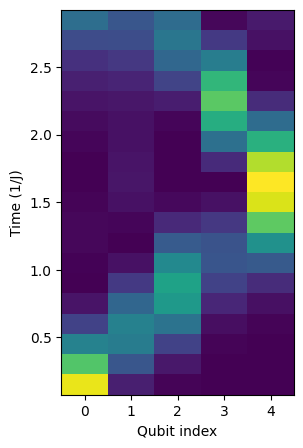

In [10]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t, probability_density)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

### Hardware challenge I

````{admonition} 実機を使った量子ランダムウォーク
実機のハードウェアで量子ランダムウォークの回路を実行し、各量子ビットにおいて励起状態が見つかる確率を抽出してください。

```python
experiment_results=job.result()

probability_density_exp=[]
for output in experiment_results.get_counts():
    ps=[]
    
    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    
    ###DO NOT EDIT BELOW
    
    probability_density_exp.append(ps)

plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(-.5,num_qubits,1), time_steps*delta_t, probability_density_exp)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')
```
````

```{caution}
以下のコードは実機を扱うためコメントアウトしています。
```

In [11]:
# from qiskit.tools.monitor import job_monitor
# from qiskit import IBMQ

# # Loading your IBM Quantum account
# IBMQ.load_account()
# IBMQ.providers() # see a list of providers you have access to

In [12]:
# # Get the special provider assigned to you using information from the output above
# hub_name = 'YOUR_HUB_NAME' # e.g. 'qc-spring-22-1'
# group_name = 'YOUR_GROUP_NAME' # e.g. 'group-2'
# project_name = 'YOUR_PROJECT_NAME' # e.g. 'recPdHH04wfWiNHjG'
# provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)

# # Get `ibm_nairobi` backend from the provider
# backend_name = 'ibm_nairobi'
# backend = provider.get_backend(backend_name)
# backend # See details of the `ibm_nairobi` quantum system

In [13]:
# initial_layout=[0 , 1 , 3 , 5 , 4]

# hardware_transpiled_circuits=[]
# for circ in circuits:
    
#     hardware_circ=deepcopy(circ)
#     hardware_circ.barrier()
#     hardware_circ.measure(range(num_qubits), range(num_qubits))
#     hardware_transpiled_circuits.append(transpile(hardware_circ, backend, initial_layout=initial_layout, optimization_level=3))

In [14]:
# shots=1024
# job = execute(hardware_transpiled_circuits, backend=backend, shots=shots)
# job_monitor(job)
# print('Job ID', job.job_id())

In [15]:
# experiment_results=job.result()

# probability_density_exp=[]
# for output in experiment_results.get_counts():
#     ps=[]
    
#     ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    
#     ###DO NOT EDIT BELOW
    
#     probability_density_exp.append(ps)

# plt.figure(figsize=(3,5), facecolor='white')
# plt.pcolormesh(np.arange(-.5,num_qubits,1), time_steps*delta_t, probability_density_exp)
# plt.xlabel('Qubit index')
# plt.ylabel('Time (1/J)')

## アンダーソン局在

粒子輸送は、格子のエネルギーの乱れの導入よって大きな影響を受け、アンダーソン局在を導きます。格子の不均一性が散乱の原因となり、量子干渉によって粒子の伝搬を抑止する傾向、つまり局在性の兆候を導きます。局在化された粒子の波動関数は急速に最初の位置から減衰し、粒子は格子の小さな領域に効果的に閉じ込められます。

フィリップ・アンダーソンは、1958年に初めて、無秩序から生まれる散乱が伝搬を完全に停止する可能性があることを示しました[1]。アンダーソンによる発見以前、科学者たちは、電子を点状の粒子として扱い、電子をランダムに散乱させる摂動として結晶の無秩序性をモデル化していました。この論理は、オームの法則に基づくブラウン運動を媒介とした伝搬として記述されました。しかし、アンダーソンは周期的な結晶中の電子の波動関数の進化に及ぼす無秩序の効果について再検討しました[2]。アンダーソンは、量子力学的領域において問題を分析し、つまり、電子の波の性質の基本的な計算を行なうことで、電子の古典的拡散運動が破錠し、電子の波動関数が、広い範囲の条件下において、指数関数的に局在化することを発見しました。したがって、電子が最初に一つの原子に置かれたとき、その波動関数は時間が経っても結晶全体を覆うようには広がらず、その最初の位置の周りに局在化して残るのです。よって、物質は電荷を通すのをやめ、最終的には、絶縁体になります。この局在化現象は、格子欠陥による電子の多重散乱から生じる異なる経路間の干渉の直接的な結果です。

![](./resources/2022-spring-lab2-tb-model.jpg)

アンダーソン局在を強結合ハミルトニアンを使って学ぶことができます。格子エネルギーに無秩序性がある場合のハミルトニアンは次の形式を取ります： 
$$H_{\rm tb}/\hbar = \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1}) + \sum_i \epsilon_i Z_i $$

$\epsilon_i$の値を変えることで、Aubry-Andre (AA) 準結晶を作り、無秩序性を模倣し、アンダーソン局在を導くことができます。この格子モデルでは、$\epsilon_i=W \rm{cos}(2\pi\beta i)$であり、$W$は無秩序性の強さで、$\beta$は準結晶の周期性を決定します。

[1] https://physicstoday.scitation.org/doi/10.1063/1.3206091?feed=most-cited  
[2] https://www.nature.com/articles/nphoton.2013.30

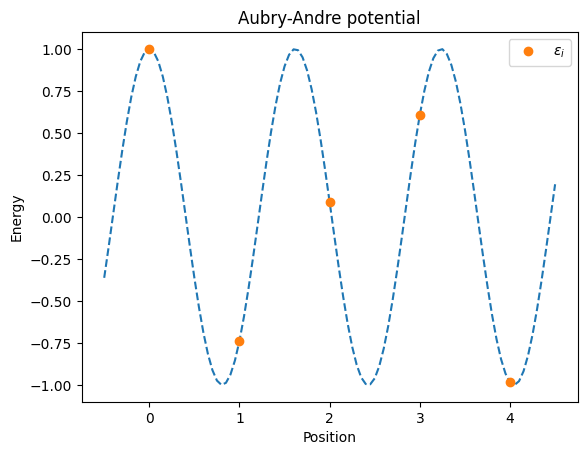

In [16]:
beta=(np.sqrt(5)-1)/2 # DO NOT EDIT
AA_patern=np.cos(2*np.pi*beta*np.arange(num_qubits)) # DO NOT EDIT

plt.plot(np.linspace(-0.5,4.5,101), np.cos(2*np.pi*beta*np.linspace(-0.5,4.5,101)), '--')
plt.plot(np.arange(num_qubits), AA_patern, 'o', label=r'$\epsilon_i$')
plt.xlabel('Position')
plt.ylabel('Energy')
plt.legend()
plt.title('Aubry-Andre potential')
plt.show()

### Challenge question 2d

````{admonition} トロッターステップの修正
強結合のトロッターステップを修正して、アンダーソン局在をシミュレートするために任意の位相を含むようにしてください。

```python
Trot_qr_disorder = QuantumRegister(num_qubits)
Trot_qc_disorder = QuantumCircuit(Trot_qr_disorder, name='Trot disorder')

Trot_qc_disorder.append(Trot_tb_gate,[0,1,2,3,4])
deltas=[Parameter('delta_{:d}'.format(idx)) for idx in range(num_qubits)]

###EDIT CODE BELOW (add a parametric disorder to each qubit)


###DO NOT EDIT BELOW
    
# Convert custom quantum circuit into a gate
Trot_disorder_gate = Trot_qc_disorder.to_instruction()

Trot_qc_disorder.draw("mpl")
```
````

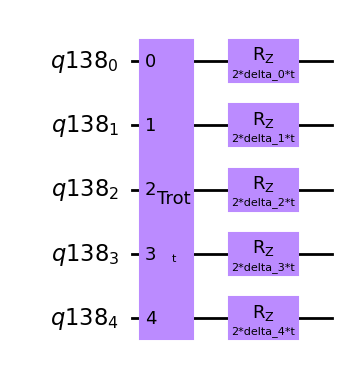

In [17]:
Trot_qr_disorder = QuantumRegister(num_qubits)
Trot_qc_disorder = QuantumCircuit(Trot_qr_disorder, name='Trot disorder')

Trot_qc_disorder.append(Trot_tb_gate,[0,1,2,3,4])
deltas=[Parameter('delta_{:d}'.format(idx)) for idx in range(num_qubits)]

for i in range(num_qubits):
    Trot_qc_disorder.rz(2 * deltas[i] * t, i)
    
# Convert custom quantum circuit into a gate
Trot_disorder_gate = Trot_qc_disorder.to_instruction()

Trot_qc_disorder.draw("mpl")

```{admonition} 解説
:class: tip
$R_Z(\lambda)= \exp (- i \lambda Z / 2)$よりそれぞれの量子ビットに$R_Z$ゲートをかければいい。
```

In [18]:
delta_t=0.15
time_steps=np.arange(1,20,1)

W=2 # DO NOT EDIT

disorders=W*AA_patern # DO NOT EDIT

disorder_circuits=[]

for n_steps in time_steps:

    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr)

    qc.x(0)
    
    for _ in range(n_steps):
        qc.append(Trot_disorder_gate, [i for i in range(num_qubits)])

    qc = qc.bind_parameters({t: delta_t})
    qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

    disorder_circuits.append(qc)

### Challenge question 2e

````{admonition} アンダーソン局在のシミュレーション
最後に、各量子ビットにおいて励起状態を発見する確率を抽出してください。

```python
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density_localization=[]
for circ in tqdm(disorder_circuits):

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    
    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    
    ###DO NOT EDIT BELOW
    
    probability_density_localization.append(ps)
    
probability_density_localization=np.array(probability_density_localization)
```
````

In [20]:
from qiskit import transpile

# Use Aer's statevector simulator
from qiskit import Aer

# Run the quantum circuit on a statevector simulator backend
backend_sim = Aer.get_backend('statevector_simulator')

probability_density_localization=[]

for circ in disorder_circuits:

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Grab the results from the job.
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    ps = outputstate.probabilities()[[2**i for i in range(num_qubits)]]
    
    probability_density_localization.append(ps)
    
probability_density_localization=np.array(probability_density_localization)

```{admonition} 解説
:class: tip
Question 2cと同様にしてそれぞれの量子ビットが1となる確率を抜き出せばいい。
```

Text(0, 0.5, 'Time (1/J)')

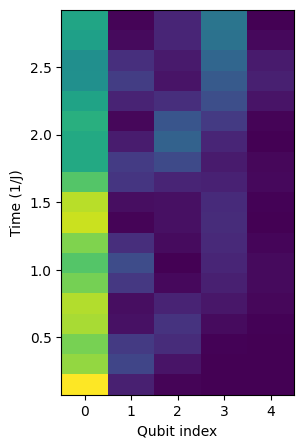

In [21]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t ,probability_density_localization)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

### Hardware challenge II

````{admonition} 量子ランダムウォークの実機シミュレーション
無秩序性のある量子ランダムウォークの回路を実機ハードウェアで実行し、各量子ビットで励起状態が見つかる確率を抽出してください。

```python
disorder_experiment_results=job_disorder.result()

disorder_probability_density_exp=[]
for output in disorder_experiment_results.get_counts():
    ps=[]
    
    ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    
    ###DO NOT EDIT BELOW
    
    disorder_probability_density_exp.append(ps)
    
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(-.5,num_qubits,1), time_steps*delta_t, disorder_probability_density_exp)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')
```
````

```{caution}
以下のコードは実機を扱うためコメントアウトしています。
```

In [ ]:
# from qiskit.tools.monitor import job_monitor

# provider = IBMQ.load_account()
# provider = IBMQ.get_provider(hub='qc-spring-2022', group='group-1', project='project-1')
# backend = provider.get_backend('ibm_nairobi')

In [ ]:
# initial_layout=[0 , 1 , 3 , 5 , 4]

# hardware_transpiled_circuits_disordered=[]
# for circ in disorder_circuits:
    
#     hardware_circ=deepcopy(circ)
#     hardware_circ.barrier()
#     hardware_circ.measure(range(num_qubits), range(num_qubits))
#     hardware_transpiled_circuits_disordered.append(transpile(hardware_circ, backend, initial_layout=initial_layout, optimization_level=3))

In [ ]:
# shots=1024
# job_disorder = execute(hardware_transpiled_circuits_disordered, backend=backend, shots=shots)
# job_monitor(job_disorder)
# print('Job ID', job_disorder.job_id())

In [ ]:
# disorder_experiment_results=job_disorder.result()

# disorder_probability_density_exp=[]
# for output in disorder_experiment_results.get_counts():
#     ps=[]
    
#     ###EDIT CODE BELOW (Extract the probability of finding the excitation on each qubit)
    
#     ###DO NOT EDIT BELOW
    
#     disorder_probability_density_exp.append(ps)
    
# plt.figure(figsize=(3,5), facecolor='white')
# plt.pcolormesh(np.arange(-.5,num_qubits,1), time_steps*delta_t, disorder_probability_density_exp)
# plt.xlabel('Qubit index')
# plt.ylabel('Time (1/J)')